# Simplify network topology and consolidate intersections

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.5.1'

## 1. Complex intersection consolidation

Many real-world street networks feature complex intersections and traffic circles, resulting in a cluster of graph nodes where there is really just one true intersection, as we would think of it in transportation or urban design. Similarly, divided roads are often represented by separate centerline edges: the intersection of two divided roads thus creates 4 nodes, representing where each edge intersects a perpendicular edge, but these 4 nodes represent a single intersection in the real world. Traffic circles similarly create a cluster of nodes where each street's edge intersects the roundabout.

OSMnx can consolidate nearby intersections and optionally rebuild the graph's topology.

많은 실제 거리 네트워크는 복잡한 교차로와 로터리를 특징으로 하며, 교통이나 도시 설계에서 생각할 수 있는 진정한 교차로가 하나 뿐인 그래프 노드 클러스터를 생성합니다. 마찬가지로 분할된 도로는 종종 별도의 중심선 가장자리로 표시됩니다. 따라서 분할된 두 도로의 교차점은 각 가장자리가 수직 가장자리와 교차하는 위치를 나타내는 4개의 노드를 생성하지만 이 4개의 노드는 실제 세계에서 단일 교차점을 나타냅니다. 로터리도 마찬가지로 각 거리의 가장자리가 원형 교차로와 교차하는 노드 클러스터를 만듭니다.

OSMnx는 가까운 교차점을 통합하고 선택적으로 그래프의 토폴로지를 재구성할 수 있습니다.

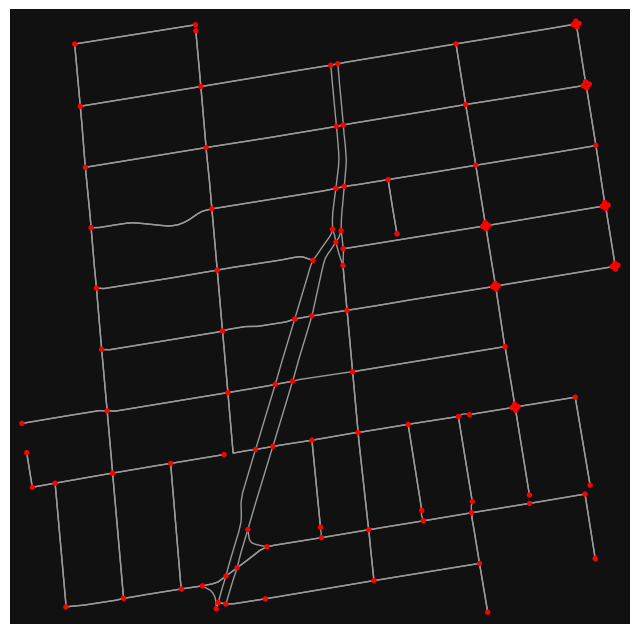

In [2]:
# get a street network and plot it with all edge intersections
point = 37.858495, -122.267468
G = ox.graph_from_point(point, network_type="drive", dist=500)
fig, ax = ox.plot_graph(G, node_color="r")

Notice the complex intersections and traffic circles creating clusters of nodes.

We'll specify that any nodes with 15 meter buffers of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of consolidated intersections.

노드 클러스터를 생성하는 복잡한 교차로와 로터리를 확인하십시오.

이 네트워크에서 서로 15미터 버퍼가 있는 모든 노드가 동일한 교차로의 일부임을 지정합니다. 조사 중인 커뮤니티의 거리 디자인 표준에 따라 이 허용 오차를 조정하고 투사된 그래프를 사용하여 미터와 같은 의미 있는 단위로 작업합니다. 또한 통합된 교차로 목록에 막다른 골목이 반환되지 않도록 지정할 것입니다.

In [3]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
ints = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=15, dead_ends=False) #15m 버퍼
len(ints)

66

In [4]:
# compare to number of nodes in original graph
len(G)

110

Note that these cleaned up intersections give us more accurate intersection counts and densities, but do not alter or integrate with the network's topology.

To do that, we need to **rebuild the graph**.

이렇게 정리된 교차점은 더 정확한 교차점 수와 밀도를 제공하지만 네트워크의 토폴로지를 변경하거나 통합하지는 않습니다.

그러기 위해서는 **그래프를 재구성**해야 합니다.

In [5]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G2)

66

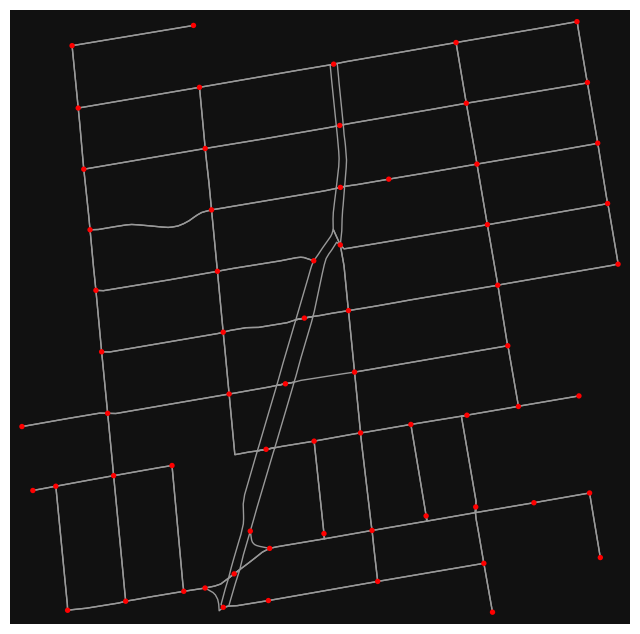

In [6]:
fig, ax = ox.plot_graph(G2, node_color="r")

Notice how the traffic circles' many nodes are merged into a new single centroid node, with edge geometries extended to connect to it. Similar consolidation occurs at the intersection of the divided roads.

Running `consolidate_intersections` with `rebuild_graph=True` may yield somewhat (but not very) different intersection counts/densities compared to `rebuild_graph=False`. The difference lies in that the latter just merges buffered node points that overlap, whereas the former checks the topology of the overlapping node buffers before merging them.

This prevents topologically remote but spatially proximate nodes from being merged. For example:

  - A street intersection may lie directly below a freeway overpass's intersection with an on-ramp. We would not want to merge these together and connnect their edges: they are distinct junctions in the system of roads.
  - In a residential neighborhood, a bollarded street may create a dead-end immediately next to an intersection or traffic circle. We would not want to merge this dead-end with the intersection and connect their edges.

These examples illustrate (two-dimensional) geometric proximity, but topological remoteness. Accordingly, in some situations we may expect higher intersection counts when using `rebuild_graph=True` because it is more cautious with merging in these cases. The trade-off is that it has higher time complexity than `rebuild_graph=False`.

## 2. Graph simplification

Use simplification to clean-up nodes that are not intersections or dead-ends while retaining the complete edge geometry. OSMnx does this automatically by default when constructing a graph.

원형 교차로의 많은 노드가 새로운 단일 중심 노드로 병합되고 연결을 위해 가장자리 지오메트리가 확장되는 방식에 주목하십시오. 분할된 도로의 교차로에서도 유사한 통합이 발생합니다.

`rebuild_graph=True`로 `consolidate_intersections`를 실행하면 `rebuild_graph=False`와 비교할 때 교차점 수/밀도가 약간 다를 수 있습니다. 차이점은 후자는 겹치는 버퍼링된 노드 포인트를 병합하는 반면 전자는 병합하기 전에 겹치는 노드 버퍼의 토폴로지를 확인한다는 것입니다.

이것은 토폴로지적으로 멀리 떨어져 있지만 공간적으로 근접한 노드가 병합되는 것을 방지합니다. 예를 들어:

   - 도로 교차로는 진입로가 있는 고속도로 육교 교차로 바로 아래에 있을 수 있습니다. 우리는 이것들을 함께 병합하고 가장자리를 연결하고 싶지 않을 것입니다. 그들은 도로 시스템에서 별개의 교차점입니다.
   - 주거 지역에서 기둥이 있는 도로는 교차로나 로터리 바로 옆에 막다른 골목을 만들 수 있습니다. 우리는 이 막다른 골목을 교차점과 병합하고 가장자리를 연결하고 싶지 않을 것입니다.

이러한 예는 (2차원) 기하학적 근접성을 설명하지만 위상학적 원격성을 설명합니다. 따라서 일부 상황에서는 병합에 더 신중하기 때문에 `rebuild_graph=True`를 사용할 때 교차 수가 더 높을 것으로 예상할 수 있습니다. 단점은 `rebuild_graph=False`보다 시간 복잡도가 높다는 것입니다.



## 2. 그래프 단순화

단순화를 사용하여 완전한 가장자리 형상을 유지하면서 교차점이나 막다른 골목이 아닌 노드를 정리합니다. OSMnx는 그래프를 구성할 때 기본적으로 이 작업을 자동으로 수행합니다.

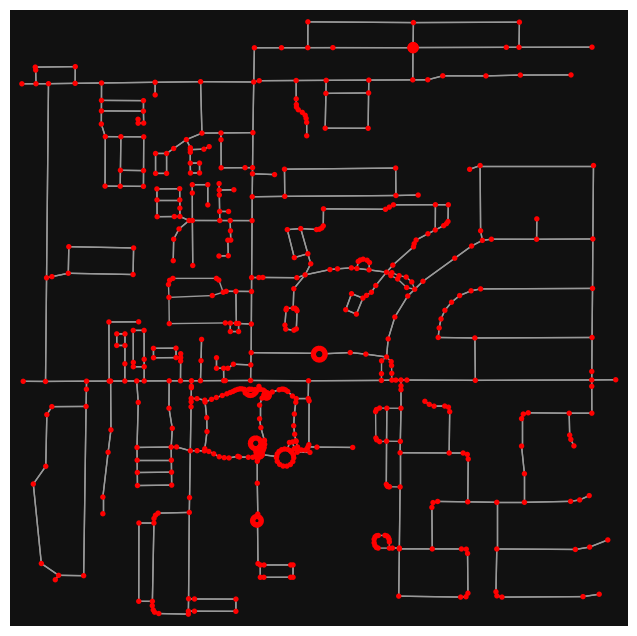

In [7]:
# create a network around some (lat, lng) point and plot it
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, dist=500, simplify=False)
fig, ax = ox.plot_graph(G, node_color="r")

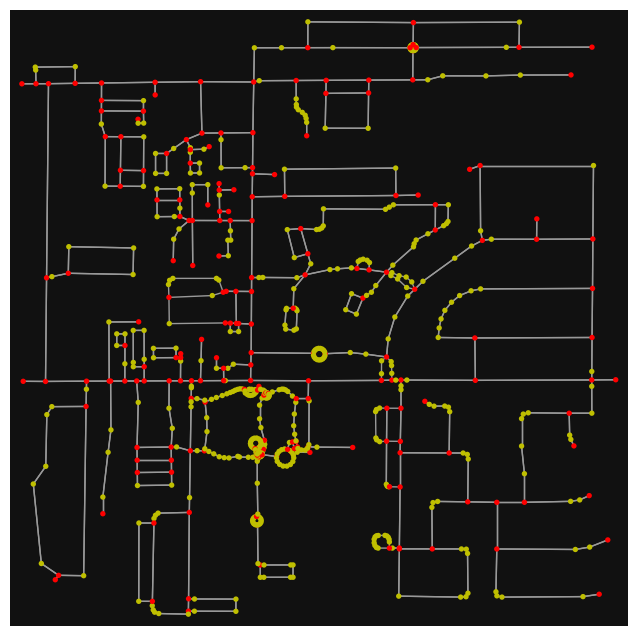

In [8]:
# show which nodes we'd remove if we simplify it (yellow)
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

In [9]:
# simplify the network
G2 = ox.simplify_graph(G)

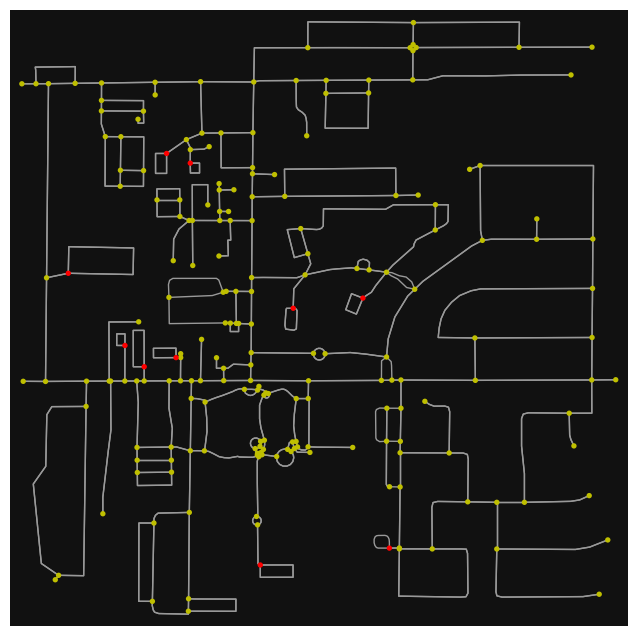

In [10]:
# plot the simplified network and highlight any self-loop edges
loops = [edge[0] for edge in nx.selfloop_edges(G2)]
nc = ["r" if node in loops else "y" for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc)

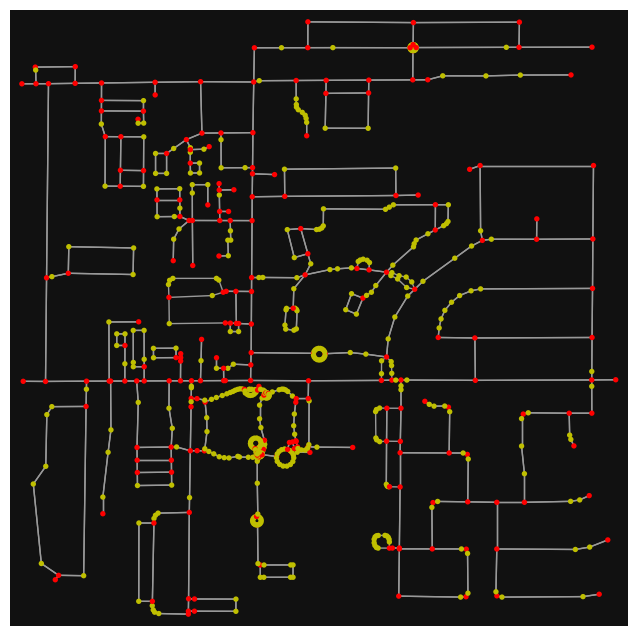

In [11]:
# turn off strict mode and see what nodes we'd remove
nc = ["r" if ox.simplification._is_endpoint(G, node, strict=False) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

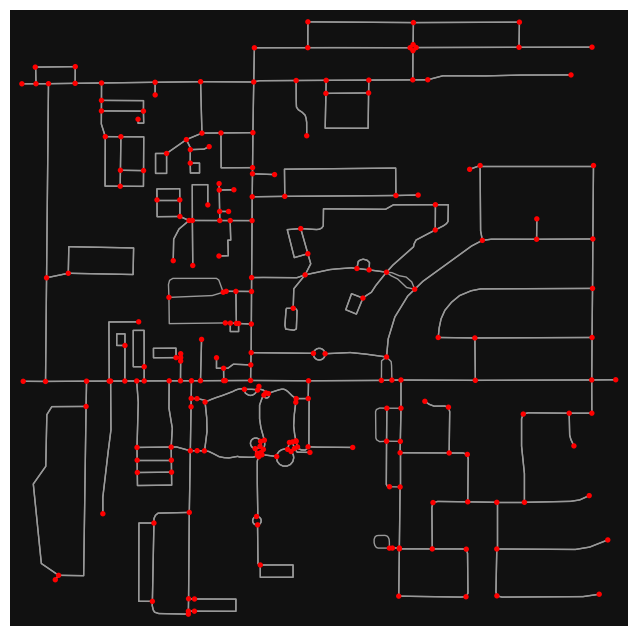

In [12]:
# simplify network with strict mode turned off
G3 = ox.simplify_graph(G.copy(), strict=False)
fig, ax = ox.plot_graph(G3, node_color="r")

## 3. Cleaning up the periphery of the network

This is related to simplification. OSMnx by default (with clean_periphery parameter equal to True) buffers the area you request by 0.5km, and then retrieves the street network within this larger, buffered area. Then it simplifies the topology so that nodes represent intersections of streets (rather than including all the interstitial OSM nodes). Then it calculates the (undirected) degree of each node in this larger network. Next it truncates this network by the actual area you requested (either by bounding box, or by polygon). Finally it saves a dictionary of node degree values as a graph attribute.

This has two primary benefits. First, it cleans up stray false edges around the periphery. If clean_periphery=False, peripheral non-intersection nodes within the requested area appear to be cul-de-sacs, as the rest of the edge leading to an intersection outside the area is ignored. If clean_periphery=True, the larger graph is first created, allowing simplification of such edges to their true intersections, allowing their entirety to be pruned after truncating down to the actual requested area. Second, it gives accurate node degrees by both a) counting node neighbors even if they fall outside the retained network (so you don't claim a degree-4 node is degree-2 because only 2 of its neighbors lie within the area), and b) not counting all those stray false edges' terminus nodes as cul-de-sacs that otherwise grossly inflate the count of nodes with degree=1, even though these nodes are really just interstitial nodes in the middle of a chopped-off street segment between intersections.

See two examples below.


## 3. 네트워크 주변 정리

이것은 단순화와 관련이 있습니다. 기본적으로 OSMnx(clean_periphery 매개변수가 True인 경우)는 요청한 영역을 0.5km까지 버퍼링한 다음 이 더 큰 버퍼 영역 내에서 거리 네트워크를 검색합니다. 그런 다음 노드가 거리의 교차점을 나타내도록 토폴로지를 단순화합니다(모든 중간 OSM 노드를 포함하는 대신). 그런 다음 이 더 큰 네트워크에서 각 노드의 (무방향) 차수를 계산합니다. 그런 다음 요청한 실제 영역(경계 상자 또는 다각형)에 따라 이 네트워크를 자릅니다. 마지막으로 노드 차수 값 사전을 그래프 속성으로 저장합니다.

여기에는 두 가지 주요 이점이 있습니다. 첫째, 주변 주변의 잘못된 잘못된 가장자리를 정리합니다. clean_periphery=False인 경우 요청된 영역 내의 주변 비교차 노드는 영역 외부의 교차점으로 이어지는 나머지 가장자리가 무시되므로 막다른 골목으로 나타납니다. clean_periphery=True인 경우 더 큰 그래프가 먼저 생성되어 이러한 가장자리를 실제 교차점으로 단순화하여 실제 요청 영역으로 자른 후 전체를 잘라낼 수 있습니다. 둘째, a) 노드 이웃이 유지된 네트워크 외부에 있더라도 계산하여 정확한 노드 차수를 제공합니다(따라서 이웃 중 2개만 영역 내에 있기 때문에 차수 4 노드가 차수 2라고 주장하지 않음) b) 이러한 노드가 잘려진 거리의 한가운데에 있는 간극 노드일지라도 도가 1인 노드의 수를 크게 부풀리는 막다른 골목으로 모든 길 잃은 거짓 에지의 종점 노드를 계산하지 않습니다. 교차로 사이의 세그먼트.

아래 두 가지 예를 참조하십시오.

In [19]:
# get some bbox
bbox = ox.utils_geo.bbox_from_point((37.5333,127.0013), dist=300)
north, south, east, west = bbox

c:\Users\Uh\AppData\Local\Programs\Python\Python311\Lib\site-packages\osmnx\graph.py:89: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  G = graph_from_polygon(


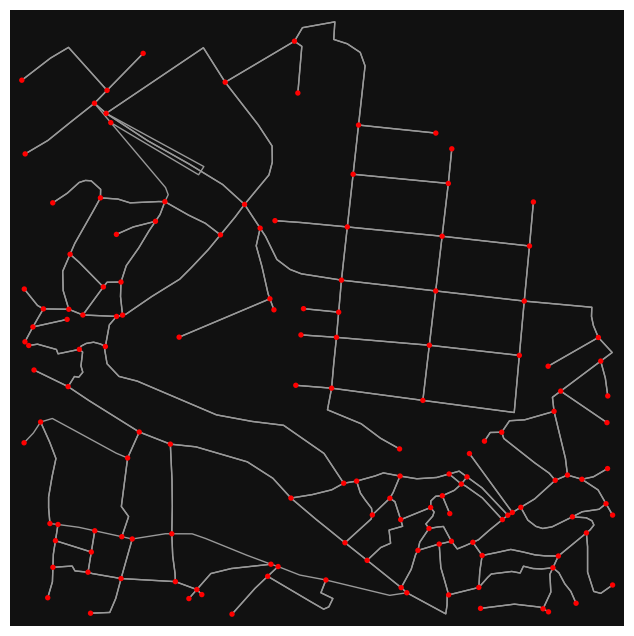

In [20]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive", clean_periphery=False)
fig, ax = ox.plot_graph(G, node_color="r")

In [22]:
# the node degree distribution for this graph has many false cul-de-sacs
k = dict(G.degree())
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 1, 2: 38, 3: 2, 4: 8, 5: 2, 6: 75, 7: 3, 8: 13}

Above, notice all the peripheral stray edge stubs. Below, notice these are cleaned up and that the node degrees are accurate with regards to the wider street network that may extend beyond the limits of the requested area.

위에서 모든 주변 스트레이 에지 스텁을 확인하십시오. 아래에서 이들이 정리되고 노드 각도가 요청된 영역의 한계를 넘어 확장될 수 있는 더 넓은 거리 네트워크와 관련하여 정확하다는 점에 유의하십시오.

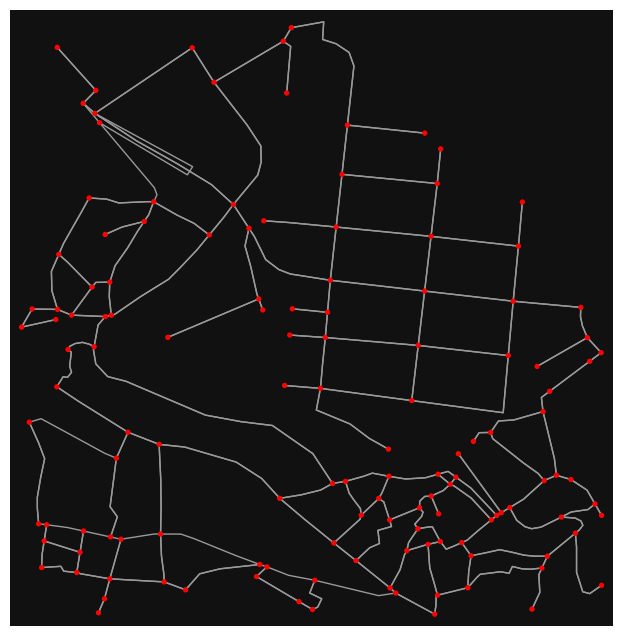

In [23]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
fig, ax = ox.plot_graph(G, node_color="r")

In [17]:
# the streets per node distribution for this cleaned up graph is more accurate
# dict keys = count of streets emanating from the node (ie, intersections and dead-ends)
# dict vals = number of nodes with that count
k = nx.get_node_attributes(G, "street_count")
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 0, 2: 0, 3: 3, 4: 57}

A final example. Compare the network below to the ones in the section above. It has the stray peripheral edges cleaned up. Also notice toward the bottom left, two interstitial nodes remain in that east-west street. Why? These are actually intersections, but their (southbound) edges were removed because these edges' next intersections were south of the requested area's boundaries. However, OSMnx correctly kept these nodes in the graph because they are in fact intersections and should be counted in measures of intersection density, etc.

마지막 예입니다. 아래 네트워크를 위 섹션의 네트워크와 비교하십시오. 길 잃은 주변 가장자리가 정리되었습니다. 또한 왼쪽 하단을 보면 동서 거리에 두 개의 간극 노드가 남아 있습니다. 왜? 이들은 실제로 교차점이지만 이러한 모서리의 다음 교차점이 요청된 영역 경계의 남쪽에 있었기 때문에 해당 모서리(남쪽 방향) 모서리가 제거되었습니다. 그러나 OSMnx는 이러한 노드가 실제로 교차하고 교차 밀도 등의 측정에서 계산되어야 하기 때문에 그래프에서 이러한 노드를 올바르게 유지했습니다.

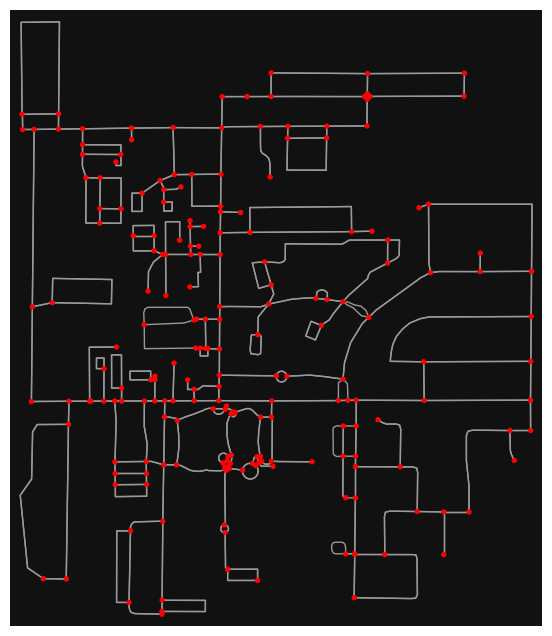

In [18]:
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, dist=500, simplify=True)
fig, ax = ox.plot_graph(G, node_color="r")